In [1]:
!pip install geopandas
import geopandas as gpd
import numpy as np
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Load shapefiles

In [3]:
# Read shapefiles
pred_boxes_galbyveien = gpd.read_file('/content/drive/MyDrive/NOVA_course_deep_learning/data/tiles/10m_galbyveien_20230504_sun/predict_YOLOm_b64_Raul/10m_galbyveien_20230504_sun_predictions_OwnAnnotations.shp')
pred_boxes_hobol = gpd.read_file('/content/drive/MyDrive/NOVA_course_deep_learning/data/tiles/10m_ortho_hobol_042222_mavic_sun/predict_YOLOm_b64_Raul/10m_ortho_hobol_042222_mavic_sun_predictions_OwnAnnotations.shp')
pred_boxes_braatan = gpd.read_file('/content/drive/MyDrive/NOVA_course_deep_learning/data/tiles/10m_braatan_40m_20230605_sun/predict_YOLOm_b64_Raul/10m_braatan_40m_20230605_sun_predictions_OwnAnnotations.shp')

pred_boxes = gpd.GeoDataFrame(pd.concat([pred_boxes_galbyveien, pred_boxes_hobol, pred_boxes_braatan]))

ref_boxes = gpd.read_file('/content/drive/MyDrive/NOVA_course_deep_learning/data/map_data/test_annotations2_sun.geojson')
aois = gpd.read_file('/content/drive/MyDrive/NOVA_Deep/Processing/aois.geojson')  # Shapefile containing multiple AOIs

# plots

<ipython-input-4-4fe2b40c2d57>:22: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


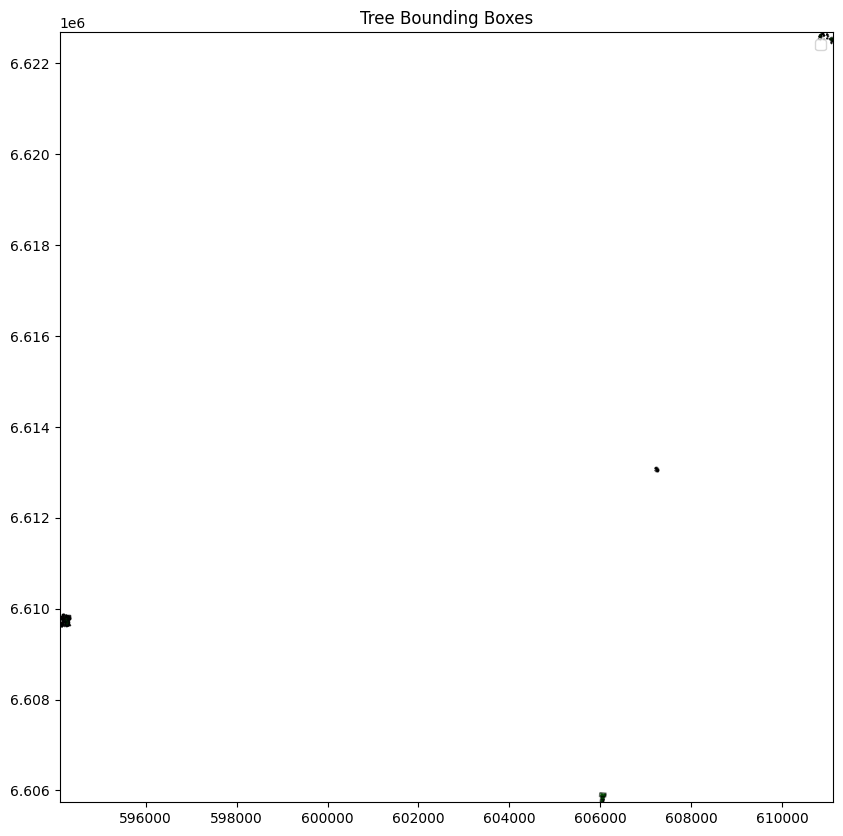

In [4]:
import matplotlib.pyplot as plt

# Plotting the shapefiles
fig, ax = plt.subplots(figsize=(10, 10))

# Plot predicted boxes
pred_boxes.plot(ax=ax, color='red', edgecolor='black', alpha=0.5, label='Predicted Boxes')

# Plot reference boxes
ref_boxes.plot(ax=ax, color='blue', edgecolor='black', alpha=0.5, label='Reference Boxes')

# Plot AOI
aois.plot(ax=ax, color='green', edgecolor='black', alpha=0.5, label='AOI')
pred_boxes_hobol.plot

# Zoom to the extent of predicted boxes
ax.set_xlim(pred_boxes.total_bounds[0], pred_boxes.total_bounds[2])
ax.set_ylim(pred_boxes.total_bounds[1], pred_boxes.total_bounds[3])

# Set plot title and legend
plt.title('Tree Bounding Boxes')
plt.legend()

# Display the plot
plt.show()

# Compute residuals

In [7]:
# Initialize lists to store residuals for each AOI
residuals = []

# Compute residuals for each AOI
for aoi in aois.iterrows():
    aoi_geom = aoi[1].geometry
    pred_within_aoi = pred_boxes[pred_boxes.geometry.within(aoi_geom)]
    ref_within_aoi = ref_boxes[ref_boxes.geometry.within(aoi_geom)]

    num_pred_within_aoi = len(pred_within_aoi)
    num_ref_within_aoi = len(ref_within_aoi)

    residual = num_pred_within_aoi - num_ref_within_aoi
    residuals.append(residual)


In [8]:
residuals

[-220, -179, -85, -226, -148, -207, -134, -100, -541, -320, -233, -127]

# Compute RMSE

In [9]:
# Compute RMSE
rmse = np.sqrt(np.mean(np.power(residuals, 2)))
bias= np.mean(residuals)
print("the RMSE is: "+ str(rmse))
print("the bias is: "+ str(bias))

the RMSE is: 240.99619637385703
the bias is: -210.0


In [ ]:
aois

,id,aoi_name,geometry
0,NaN,NaN,"MULTIPOLYGON (((594269.014 6609757.765, 594234..."
1,NaN,NaN,"MULTIPOLYGON (((594234.465 6609756.975, 594269..."
2,NaN,NaN,"MULTIPOLYGON (((594273.794 6609722.675, 594304..."
3,NaN,NaN,"MULTIPOLYGON (((594258.021 6609690.758, 594295..."
4,NaN,NaN,"MULTIPOLYGON (((611118.906 6622547.070, 611131..."
5,NaN,NaN,"MULTIPOLYGON (((611056.437 6622561.621, 611107..."
6,NaN,NaN,"MULTIPOLYGON (((610822.431 6622609.162, 610812..."
7,NaN,NaN,"MULTIPOLYGON (((610832.842 6622641.087, 610822..."
8,NaN,NaN,"MULTIPOLYGON (((605992.036 6605951.721, 606129..."
9,NaN,NaN,"MULTIPOLYGON (((606010.974 6605864.371, 606007..."


In [10]:



# Print residuals and RMSE
for i, aoi in enumerate(aois.iterrows()):
    aoi_name = aoi[1]['aoi_name']  # Assuming you have a column 'aoi_name' in your AOIs shapefile
    print("Residual for AOI"+ str(aoi_name) + ":" +str(residuals[i]))

print("RMSE:"+  str(rmse))

Residual for AOInan:-220
Residual for AOInan:-179
Residual for AOInan:-85
Residual for AOInan:-226
Residual for AOInan:-148
Residual for AOInan:-207
Residual for AOInan:-134
Residual for AOInan:-100
Residual for AOInan:-541
Residual for AOInan:-320
Residual for AOInan:-233
Residual for AOInan:-127
RMSE:240.99619637385703


# Now we are going to per hectare values

In [11]:
# Initialize lists to store the number of boxes per hectare for each AOI
box_density = []

# Compute the number of boxes per hectare for each AOI
for aoi in aois.iterrows():
    aoi_geom = aoi[1].geometry
    pred_within_aoi = pred_boxes[pred_boxes.geometry.within(aoi_geom)]
    ref_within_aoi = ref_boxes[ref_boxes.geometry.within(aoi_geom)]

    area = aoi_geom.area  # Area in square meters
    area_ha = area / 10000  # Convert area to hectares
    num_pred_within_aoi = len(pred_within_aoi)
    num_ref_within_aoi = len(ref_within_aoi)

    pred_density = num_pred_within_aoi / area_ha
    ref_density = num_ref_within_aoi / area_ha

    box_density.append((pred_density, ref_density))

In [ ]:
box_density

[(510.8020286467114, 2294.555144555862),
 (726.8525497999442, 2257.5185076139446),
 (660.9535800566351, 1346.0883886519275),
 (801.7009830206717, 2206.2313873824687),
 (246.79805044818747, 962.9963144939079),
 (259.86232819312374, 1404.3623693841157),
 (60.78266652787089, 1224.336568632828),
 (117.77544243101669, 902.9450586377947),
 (158.26693708541913, 623.6061379724395),
 (236.45855714568236, 792.831632782582),
 (157.12870241011558, 757.3088280094096),
 (0.0, 314.5974496443633)]

In [ ]:

# Print box density for each AOI
for i, aoi in enumerate(aois.iterrows()):
    aoi_name = aoi[1]['aoi_name']  # Assuming you have a column 'aoi_name' in your AOIs shapefile
    pred_density, ref_density = box_density[i]
    print("Box density for AOI"+ str(aoi_name) + ":")
    print("Predicted density (boxes/ha):"+ str(pred_density))
    print("Reference density (boxes/ha):"+ str(ref_density))
    print()


Box density for AOInan:
Predicted density (boxes/ha):510.8020286467114
Reference density (boxes/ha):2294.555144555862

Box density for AOInan:
Predicted density (boxes/ha):726.8525497999442
Reference density (boxes/ha):2257.5185076139446

Box density for AOInan:
Predicted density (boxes/ha):660.9535800566351
Reference density (boxes/ha):1346.0883886519275

Box density for AOInan:
Predicted density (boxes/ha):801.7009830206717
Reference density (boxes/ha):2206.2313873824687

Box density for AOInan:
Predicted density (boxes/ha):246.79805044818747
Reference density (boxes/ha):962.9963144939079

Box density for AOInan:
Predicted density (boxes/ha):259.86232819312374
Reference density (boxes/ha):1404.3623693841157

Box density for AOInan:
Predicted density (boxes/ha):60.78266652787089
Reference density (boxes/ha):1224.336568632828

Box density for AOInan:
Predicted density (boxes/ha):117.77544243101669
Reference density (boxes/ha):902.9450586377947

Box density for AOInan:
Predicted density

In [ ]:

# Compute RMSE of box density
pred_densities, ref_densities = zip(*box_density)
residuals = np.array(pred_densities) - np.array(ref_densities)
rmse = np.sqrt(np.mean(np.power(residuals, 2)))
bias = np.mean(residuals)

rmse_rel= rmse/np.mean(ref_densities)*100
bias_rel= bias/np.mean(ref_densities)*100

print("RMSE of box density (boxes/ha):"+ str(rmse))
print("relative RMSE of box density (%):"+ str(rmse_rel))

print("bias of box density (boxes/ha):"+ str(bias))
print("relative bias of box density (%):"+ str(bias_rel))


RMSE of box density (boxes/ha):1030.5854902409071
relative RMSE of box density (%):81.96935250685236
bias of box density (boxes/ha):-929.1663301663554
relative bias of box density (%):-73.9028088170547
